# Create a Toy Example to Test EMOGI
Here, we create a little toy example of a graph with ~100 nodes, ~300 edges and three cliques inserted. We will assign multi-omics features of known cancer genes to the clique nodes and those of non-cancer genes to the other nodes.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import sys, os, h5py
sys.path.append(os.path.abspath('../EMOGI'))
import gcnPreprocessing
import gcnIO
import matplotlib.pyplot as plt
%matplotlib inline

## Load Existing Data

In [2]:
data = gcnIO.load_hdf_data('../data/pancancer/all_omics_final_CPDB/CPDB_multiomics.h5')
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
features_df = pd.DataFrame(features, index=node_names[:, 1], columns=feat_names)

In [3]:
y_train.shape, y_test.shape, train_mask.shape, test_mask.shape

((13627, 1), (13627, 1), (13627,), (13627,))

## Get the Simulated Network

In [4]:
toy_network = nx.read_edgelist('network.edgelist')
insert_positions = []
with open('insert_positions.txt', 'r') as f:
    for line in f.readlines():
        if line.startswith('#'): # comment
            pass
        elif line.startswith('Subnetwork'):
            positions = line.split(':')[1].strip().split('\t')
            insert_positions.append([int(i) for i in positions])
clique_nodes = np.array(insert_positions).flatten()

/home/sasse/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


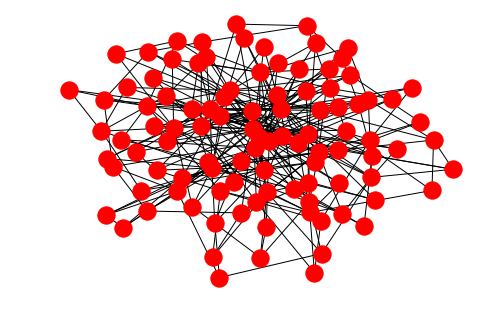

In [5]:
nx.draw(toy_network)

## Get Features & Labels

In [6]:
# select features from cancer and non-cancer genes
features_cancergenes = features_df[y_train]
features_noncancergenes = features_df[np.logical_and(train_mask, np.logical_not(y_train.flatten()))]
# start with the negatives and then update the DF
features_toynetwork = features_noncancergenes.sample(n=toy_network.number_of_nodes())
pos_features = features_cancergenes.sample(n=len(clique_nodes))
# workaround required to fool pandas indexing (otherwise it sets NaN values because indices don't match)
names = features_toynetwork.index.values
names[clique_nodes] = pos_features.index.values
features_toynetwork.set_index(names, inplace=True)
features_toynetwork.iloc[clique_nodes] = pos_features

In [7]:
features_toynetwork.isnull().all(axis=1).sum()

0

In [8]:
y_toy = pd.Series(np.zeros(toy_network.number_of_nodes()))
y_toy.iloc[clique_nodes] = 1
mask = np.ones(toy_network.number_of_nodes())
y_train, train_mask, y_test, test_mask = gcnPreprocessing.train_test_split(y_toy.values.reshape(-1, 1), mask, 0.25)
y_train, train_mask, y_val, val_mask = gcnPreprocessing.train_test_split(y_train, train_mask, 0.1)
y_train.sum(), train_mask.sum(), y_test.sum(), test_mask.sum(), 

(10.0, 68.0, 4.0, 26.0)

## Write to HDF5 Container

In [9]:
f = h5py.File('toy_example.h5', 'w')
string_dt = h5py.special_dtype(vlen=str)
names = features_toynetwork.index.values.reshape(-1, 1)
node_names_toy = np.hstack([names, names])
toy_adj = nx.to_numpy_array(toy_network)
f.create_dataset('network', data=toy_adj, shape=toy_adj.shape)
f.create_dataset('features', data=features_toynetwork, shape=features_toynetwork.shape)
f.create_dataset('gene_names', data=node_names_toy.astype('object'), dtype=string_dt)
f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_val', data=y_val, shape=y_val.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
f.create_dataset('feature_names', data=np.array(feat_names, dtype=object), dtype=string_dt)
f.create_dataset('features_raw', data=features_toynetwork, shape=features_toynetwork.shape)
f.close()